# Hidden Markov Models

## Generating data

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
#let's say we have only two hidden states
z_val = np.array([0,1])
prob = np.array([.5,.5])   #initial
A = np.array([[.98,.02],[.02,.98]]) #transition 
B_pars = np.array([[0,.5],[5,.5]])  #emission 

150


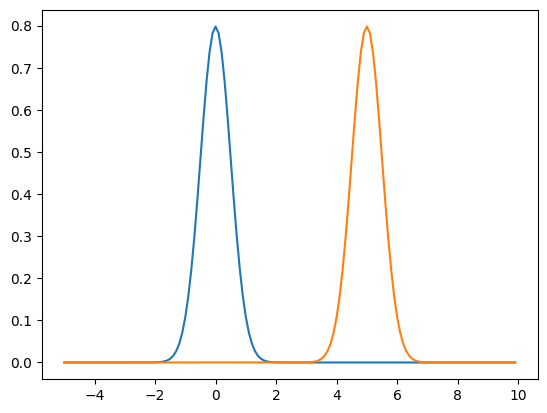

In [26]:
def gaussian(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-((x-mu)**2)/(2*sigma**2))

xt = np.arange(-5,10,.1)
y1=[]
y2=[]
for i in range(len(xt)):
    y1.append(gaussian(xt[i],B_pars[0][0], B_pars[0][1]))
    y2.append(gaussian(xt[i],B_pars[1][0], B_pars[1][1]))
    
plt.plot(xt,y1)
plt.plot(xt,y2)
print(len(xt))
plt.show()

In [27]:
N=100000 #length of sequence
z = np.empty((N))
x = np.empty((N))  #observable 

#Generating first state and emission
r = np.random.random()
if r<=prob[0]:
    z[0]=0
else:
    z[0]=1
x[0]=np.random.normal(loc=B_pars[0][0],scale=B_pars[0][1])

   
for i in range(1,N):
    if z[i-1]==0:
        c1=A[0][0]
        c2=A[0][1]+c1 #cumulative prob
        a=np.random.random()
        #print(a)
        if a<=c1:             
            z[i]=0
        else:
            z[i]=1
        #emission
        x[i]=np.random.normal(loc=B_pars[0][0],scale=B_pars[0][1])
       
            
    if z[i-1]==1:
        c1=A[1][1]
        c2=A[1][0]+c1 #cumulative prob
        a=np.random.random()
        #print(a)
        if a<=c1:
            z[i]=1
        else:
            z[i]=0
        #emission
        x[i]=np.random.normal(loc=B_pars[1][0],scale=B_pars[1][1])
       

print(z)   
print(z[-1])

[0. 0. 0. ... 0. 0. 0.]
0.0


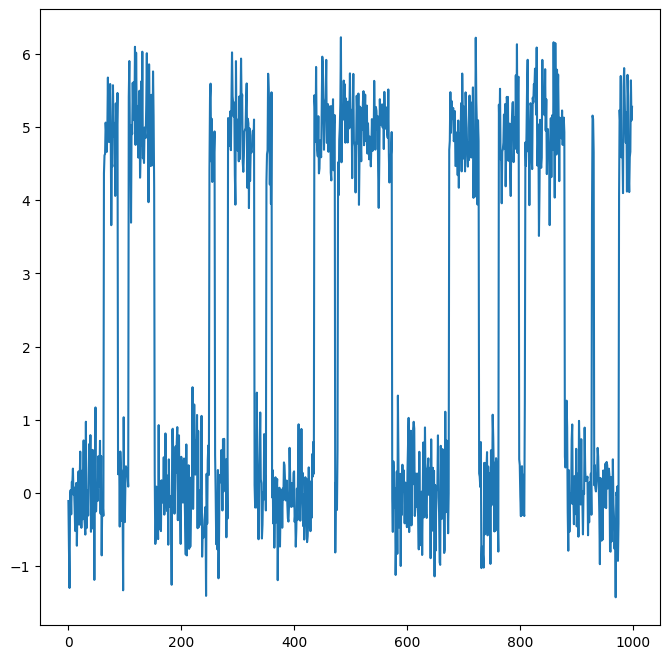

In [28]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,1000,1),x[:1000])
plt.show()

In [29]:
x_0 = x[np.where(z==0)]
print(x_0[:10])

[-0.1106306  -0.77177621 -1.29866139 -0.02100976  0.03881391 -0.29316118
  0.15109373  0.13687016  0.33210731 -0.02283742]


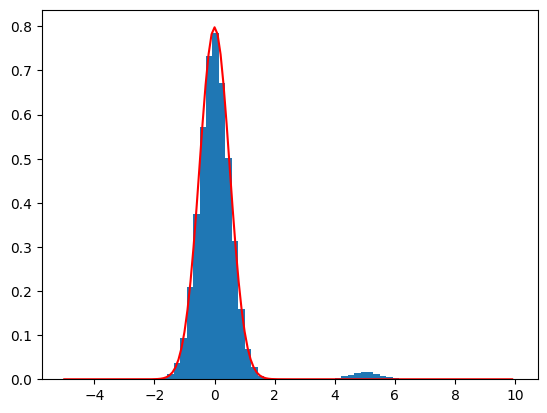

In [30]:
plt.hist(x_0, bins=70, range=(-5,10), density=True)
plt.plot(xt,y1,color='red')
plt.show()

In [31]:
#unique_0, counts_0 = np.unique(x_0, return_counts=True)

In [32]:
#plt.plot(unique_0,counts_0,'o')

In [33]:
x_0.mean()

0.10089149277233582

In [34]:
x_1 = x[np.where(z==1)]

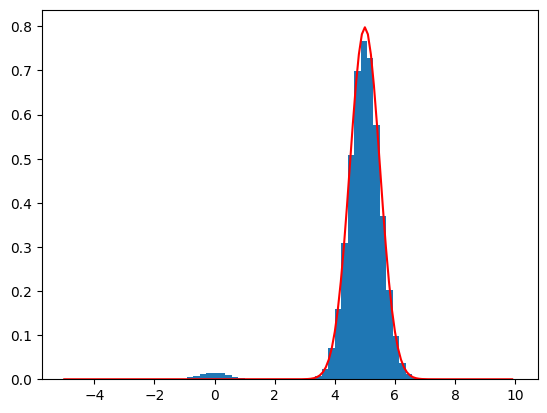

In [35]:
plt.hist(x_1, bins=70, range=(-5,10), density=True)
plt.plot(xt,y2,color='red')
plt.show()

In [36]:
#plt.plot(unique_1,counts_1,'o')

In [37]:
x_1.mean()

4.904613553587605

## Forward Algorithm

In [38]:
z_val = np.array([0,1])  #states
prob = np.array([.5,.5])   #initial
A = np.array([[.98,.02],[.02,.98]]) #transition 
B_pars = np.array([[0,.5],[5,.5]])  #emission 
transition_probability ={
    0 : {0 :0.98 ,1 : 0.02}, 
    1 : {0: 0.02, 1: 0.98}
    }
emission_probability={
    0 : {0 : 0 , 1 : .5},
    1 : {0 : 5 , 1 : .5}
    }
obs =np.array([0,1])

print(enumerate(reversed(obs[1:])))

In [39]:
def frwd_bkwd(observations, states, start_prob, trans_prob, emm_prob, end_st):
    """Forward–backward algorithm."""
    # Forward part of the algorithm
    fwd = []
    for i, observation_i in enumerate(observations):
        f_curr = {}
        for st in states:
            if i == 0:
                # base case for the forward part
                prev_f_sum = start_prob[st]
            else:
                prev_f_sum = sum(f_prev[k] * trans_prob[k][st] for k in states)

            f_curr[st] = emm_prob[st][observation_i] * prev_f_sum

        fwd.append(f_curr)
        f_prev = f_curr

    p_fwd = sum(f_curr[k] * trans_prob[k][end_st] for k in states)
    
    # Backward part of the algorithm
    bkw = []
    for i, observation_i_plus in enumerate(reversed(observations[1:])):
        b_curr = {}
        for st in states:
            if i == 0:
                # base case for backward part
                b_curr[st] = trans_prob[st][end_st]
            else:
                b_curr[st] = sum(trans_prob[st][l] * emm_prob[l][observation_i_plus] * b_prev[l] for l in states)

        bkw.insert(0,b_curr)
        b_prev = b_curr

    p_bkw = sum(start_prob[l] * emm_prob[l][observations[0]] * b_curr[l] for l in states)


    return fwd, bkw

In [40]:
forward, backward=frwd_bkwd(observations=obs,
                               states=z_val, 
                               start_prob=prob, 
                               trans_prob=transition_probability, 
                               emm_prob=emission_probability, 
                               end_st=z[-1])
print("forward=", forward, '\n', "backward=", backward)

forward= [{0: 0.0, 1: 2.5}, {0: 0.025, 1: 1.225}] 
 backward= [{0: 0.98, 1: 0.02}]


### I wrote this part by myself

In [60]:
z_val = np.array([0,1])  #states
prob = np.array((.5,.5))   #initial
A = np.array(((.98,.02),(.02,.98))) #transition 
B = np.array(((0,.5),(5,.5)))  #emission 

def forward(obs, transition, emission, initial):
    
    alpha = [np.zeros((obs.shape[0], transition[0].shape[0]))]
    alpha[:,0] = initial*emission[:,obs[0]]
    for i in range (1,obs.shape[0]):
        for j in range(transition[0].shape[0]):
            alpha[i,j]= alpha[t-1].dot(transition[:,j])*emission[j,obs[i]]
        
    return alpha

In [61]:
forward(obs=x , transition=A , emission= B, initial=prob )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [59]:
def forw(obs, transition, emission, initial):
    
    alpha = [np.zeros((obs.shape[0], transition[0].shape[0]))]
    #alpha[0,:] = initial*emission[:,obs[0]]
    for i in range (0,obs.shape[0]):
        if i == 0:
            alpha[:,0] = initial*emission[:,i]
        else:
            for j in range(transition[0].shape[0]):
                alpha[i,j]= alpha[i-1]*(transition[:,j])*emission[j,i]
        
    return alpha


forw(x,A,B,prob)

TypeError: list indices must be integers or slices, not tuple

In [57]:
xshape= x.shape[0]
ashape= A[0].shape[0]
my= np.zeros((ashape, xshape))

k=np.array(((1,5), (0, 4)))
print(B.shape)
print(my.shape)
print(prob.shape)
s = prob*B[:,0]
print(my[:,0])
print(s.shape)

my[:,0]= prob*B[:,0]
print(my)


(2, 2)
(2, 100000)
(2,)
[0. 0.]
(2,)
[[0.  0.  0.  ... 0.  0.  0. ]
 [2.5 0.  0.  ... 0.  0.  0. ]]


In [73]:
def jelo(states,transitions,emissions,end):
    end = np.array([end])
    F = np.zeros((states.shape[0],end.shape[0]))
    F[0][0] = 1
    for i in range(0,states.shape[0]-1):
        F[i][1] = transitions[(states[0],states[i])]*emissions[states[i]][end[0]]
    for j in range(2,end.shape[0]+1):
        for i in range(1,states.shape[0]-1):
            p_sum = 0
            for k in range(0,states.shape[0]-1):
                p_sum += F[k][j-1]*transitions[(states[k],states[i])]*emissions[states[i]][end[j-1]]
            F[i][j] = p_sum
    p_sum = 0
    for k in range(1,states.shape[0]-1):
        p_sum += F[k][end.shape[0]]*transitions[(states[k],states[-1])]
    F[-1][-1] = p_sum
    return F

In [62]:
jelo(states=z, transitions=transition_probability , emissions=emission_probability , end= z[-1])

KeyError: (0.0, 0.0)